# Diffusion PoE for Logical AND on Curated MNIST (4 ∧ 7): Regimes A–C

We train two independent diffusion experts:
- Expert 4:  p₄(x)
- Expert 7:  p₇(x)

We test PoE composition by additive energies / scores during sampling:
$$
p(x)\propto p_4(x)p_7(x)
\quad\Longleftrightarrow\quad
E_{4\wedge 7}(x)=E_4(x)+E_7(x).
$$

## Regimes
**A (Support mismatch):**
Train experts on standard MNIST (single centered digit). Expected PoE failure (empty/near-empty intersection).

**B (Inductive-bias mismatch):**
Use curated multi-digit canvas (overlap possible), but train experts on center-biased data distribution (centered placements). Expected PoE weakness / failure due to implicit centering bias.

**C (Overlap + matched bias):**
Use curated multi-digit canvas with random placement + distractors (existential semantics). Train fully-conv experts. Expected PoE success (visible 4 and 7 co-occurrence).

## Additions included
- train by steps (not epochs)
- EMA, sample from EMA
- Bigger fully-conv model
- DDIM sampling (+ optional ancestral DDPM)
- PoE eps normalization + weight sweep
- Existential evaluation via sliding-window classifier
- Optional distractors in dataset


In [1]:
import math, time, random
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

def seed_all(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def show_images_grid(x, title="", nrow=4, pad=2):
    x = x.detach().cpu()
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x.clamp(0, 1)
    grid = make_grid(x, nrow=nrow, padding=pad).permute(1,2,0).numpy()
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.axis("off")
    if grid.shape[2] == 1:
        plt.imshow(grid[...,0], cmap="gray", vmin=0, vmax=1)
    else:
        plt.imshow(grid, vmin=0, vmax=1)
    plt.show()


device: cuda


## MNIST base glyphs
We use MNIST (28×28) as glyphs to generate curated canvases (e.g. 48×48).


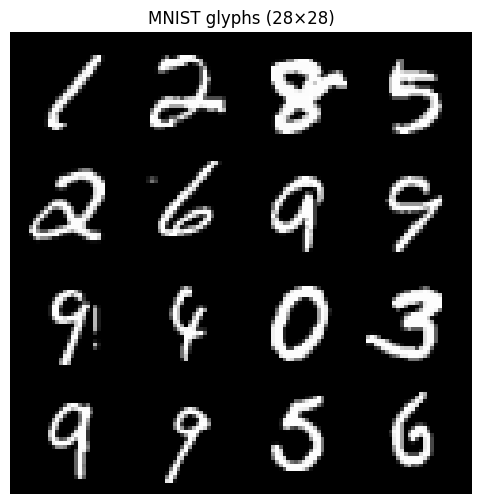

labels: [1, 2, 8, 5, 2, 6, 9, 9, 9, 4, 0, 3, 9, 9, 5, 6]


In [2]:
tfm = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

x0, y0 = next(iter(DataLoader(mnist_train, batch_size=16, shuffle=True)))
show_images_grid(x0, "MNIST glyphs (28×28)")
print("labels:", y0.tolist()[:16])


## Dataset: TwoDigitMNISTCanvasClean + minimal extension with distractors

- `TwoDigitMNISTCanvasClean`: your clean non-overlapping canvas dataset with existential labels.
- `TwoDigitMNISTCanvasCleanPlus`: adds optional distractors (extra random digits) while preserving non-overlap logic.


In [3]:
# ---------- helpers: ink masks + dilation ----------
def binarize_ink(glyph, thr=0.20, relative=True):
    g = glyph[0]
    t = (float(g.max()) * thr) if relative else thr
    return (g > t).to(torch.float32)[None, ...]

def dilate_mask(mask, radius):
    if radius <= 0:
        return mask
    k = 2 * radius + 1
    return F.max_pool2d(mask[None, ...], kernel_size=k, stride=1, padding=radius)[0]

def can_place(occupied, mask_dilated, x0, y0):
    h, w = mask_dilated.shape[-2:]
    patch = occupied[:, y0:y0+h, x0:x0+w]
    return (patch * mask_dilated).sum().item() == 0.0

def paste_max(canvas, glyph, x0, y0):
    h, w = glyph.shape[-2:]
    patch = canvas[:, y0:y0+h, x0:x0+w]
    canvas[:, y0:y0+h, x0:x0+w] = torch.maximum(patch, glyph)
    return canvas

def paste_mask(occupied, mask, x0, y0):
    h, w = mask.shape[-2:]
    patch = occupied[:, y0:y0+h, x0:x0+w]
    occupied[:, y0:y0+h, x0:x0+w] = torch.maximum(patch, mask)
    return occupied


class TwoDigitMNISTCanvasClean(Dataset):
    """
    Clean, strictly non-overlapping MNIST digits on a canvas.

    Existential labels:
      y["has4"]=1 iff a 4 exists anywhere, similarly y["has7"].

    mode: exists4 / exists7 / both47 / mixed
    """
    def __init__(
        self,
        mnist_base,
        length=60000,
        canvas_size=48,
        mode="mixed",
        p_both=0.8,
        digit_size_range=(18, 22),

        min_margin=4,
        min_gap=10,
        ink_thr=0.20,
        ink_thr_relative=True,

        enforce_side_by_side=False,
        corridor_gap=4,

        max_tries=1500,
        max_restarts=50,
        antialias_resize=True,
        seed=0
    ):
        super().__init__()
        self.mnist = mnist_base
        self.length = int(length)
        self.H = self.W = int(canvas_size)

        self.mode = mode
        self.p_both = float(p_both)

        self.sz_lo, self.sz_hi = digit_size_range
        self.min_margin = int(min_margin)
        self.min_gap = int(min_gap)
        self.ink_thr = float(ink_thr)
        self.ink_thr_relative = bool(ink_thr_relative)

        self.enforce_side_by_side = bool(enforce_side_by_side)
        self.corridor_gap = int(corridor_gap)

        self.max_tries = int(max_tries)
        self.max_restarts = int(max_restarts)
        self.antialias_resize = bool(antialias_resize)

        self.base_seed = int(seed)
        self.rng = np.random.RandomState(self.base_seed)

        self.by_digit = {d: [] for d in range(10)}
        for i in range(len(self.mnist)):
            _, y = self.mnist[i]
            self.by_digit[int(y)].append(i)

    def __len__(self):
        return self.length

    def _sample_glyph(self, digit):
        idx = self.rng.choice(self.by_digit[int(digit)])
        x, _ = self.mnist[idx]  # [1,28,28] in [0,1]
        return x.clone()

    def _resize(self, glyph, size):
        return TF.resize(glyph, [size, size], antialias=self.antialias_resize)

    def _sample_top_left(self, size, region=None):
        if region is None:
            x_min = self.min_margin
            y_min = self.min_margin
            x_max = self.W - self.min_margin - size
            y_max = self.H - self.min_margin - size
        else:
            x_min, x_max, y_min, y_max = region
            x_min = max(int(x_min), self.min_margin)
            y_min = max(int(y_min), self.min_margin)
            x_max = min(int(x_max), self.W - self.min_margin - size)
            y_max = min(int(y_max), self.H - self.min_margin - size)
        if x_max < x_min or y_max < y_min:
            return None
        x0 = int(self.rng.randint(x_min, x_max + 1))
        y0 = int(self.rng.randint(y_min, y_max + 1))
        return x0, y0

    def _choose_digits_and_labels(self):
        y = {"has4": torch.tensor(0.0), "has7": torch.tensor(0.0)}
        if self.mode == "exists4":
            digits = [4]; y["has4"] = torch.tensor(1.0)
        elif self.mode == "exists7":
            digits = [7]; y["has7"] = torch.tensor(1.0)
        elif self.mode == "both47":
            digits = [4, 7]; y["has4"] = torch.tensor(1.0); y["has7"] = torch.tensor(1.0)
        elif self.mode == "mixed":
            if self.rng.rand() < self.p_both:
                digits = [4, 7]; y["has4"] = torch.tensor(1.0); y["has7"] = torch.tensor(1.0)
            else:
                if self.rng.rand() < 0.5:
                    digits = [4]; y["has4"] = torch.tensor(1.0)
                else:
                    digits = [7]; y["has7"] = torch.tensor(1.0)
        else:
            raise ValueError(f"Unknown mode: {self.mode}")
        return digits, y

    def _side_by_side_regions_dynamic(self, size_left, size_right):
        usable_w = self.W - 2 * self.min_margin
        if size_left + size_right + self.corridor_gap > usable_w:
            return None, None
        left_block_min = size_left
        left_block_max = usable_w - self.corridor_gap - size_right
        left_block = int(self.rng.randint(left_block_min, left_block_max + 1))

        xL_min = self.min_margin
        xL_max = self.min_margin + left_block - 1
        xR_min = self.min_margin + left_block + self.corridor_gap
        xR_max = self.W - self.min_margin - 1

        region_left  = (xL_min, xL_max, self.min_margin, self.H - self.min_margin - 1)
        region_right = (xR_min, xR_max, self.min_margin, self.H - self.min_margin - 1)
        return region_left, region_right

    def __getitem__(self, idx):
        for _restart in range(self.max_restarts):
            canvas = torch.zeros(1, self.H, self.W)
            occupied = torch.zeros(1, self.H, self.W)

            digits, y = self._choose_digits_and_labels()
            sizes = [int(self.rng.randint(self.sz_lo, self.sz_hi + 1)) for _ in digits]

            regions = [None] * len(digits)
            if len(digits) == 2 and self.enforce_side_by_side:
                r0, r1 = self._side_by_side_regions_dynamic(sizes[0], sizes[1])
                if r0 is not None:
                    regions[0], regions[1] = r0, r1

            ok_all = True
            for i, d in enumerate(digits):
                glyph = self._sample_glyph(d)
                glyph = self._resize(glyph, sizes[i])

                mask = binarize_ink(glyph, thr=self.ink_thr, relative=self.ink_thr_relative)
                mask_gap = dilate_mask(mask, self.min_gap)

                placed = False
                for _ in range(self.max_tries):
                    pos = self._sample_top_left(sizes[i], region=regions[i])
                    if pos is None:
                        continue
                    x0, y0 = pos
                    if not can_place(occupied, mask_gap, x0, y0):
                        continue
                    canvas = paste_max(canvas, glyph, x0, y0)
                    occupied = paste_mask(occupied, mask, x0, y0)
                    placed = True
                    break

                if not placed:
                    ok_all = False
                    break

            if ok_all:
                x = canvas * 2.0 - 1.0
                return x, y

        raise RuntimeError("Could not generate a valid sample; relax constraints (min_gap, size_range, side_by_side).")


class TwoDigitMNISTCanvasCleanPlus(TwoDigitMNISTCanvasClean):
    """
    Minimal extension: optional distractor digits while preserving clean non-overlap logic.
    """
    def __init__(self, *args, p_extra=0.3, max_extra=1, forbid_digit=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.p_extra = float(p_extra)
        self.max_extra = int(max_extra)
        self.forbid_digit = forbid_digit

    def _choose_digits_and_labels(self):
        digits, y = super()._choose_digits_and_labels()
        if self.p_extra > 0 and self.rng.rand() < self.p_extra:
            n_extra = int(self.rng.randint(1, self.max_extra + 1))
            for _ in range(n_extra):
                d = int(self.rng.randint(0, 10))
                if self.forbid_digit is not None and d == int(self.forbid_digit):
                    d = (d + 1) % 10
                digits.append(d)
        return digits, y


def worker_init_fn(worker_id):
    info = torch.utils.data.get_worker_info()
    ds = info.dataset
    ds.rng = np.random.RandomState(ds.base_seed + 1000 * worker_id)


## Sanity check: curated samples
We visualize (random placement) and (both47 side-by-side for interpretability).


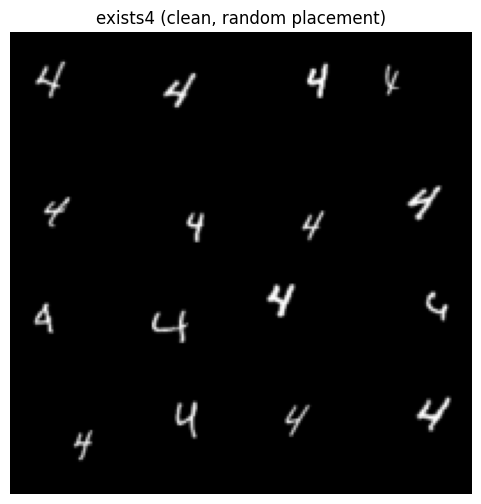

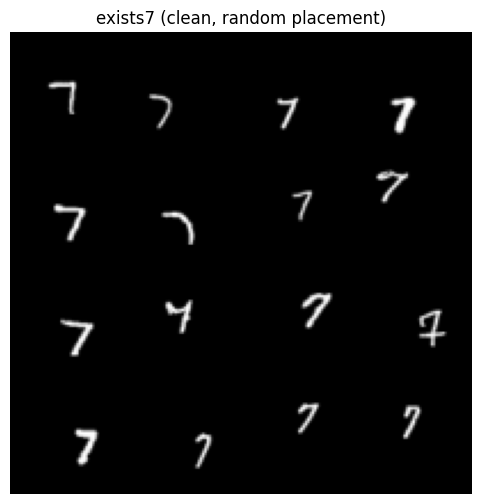

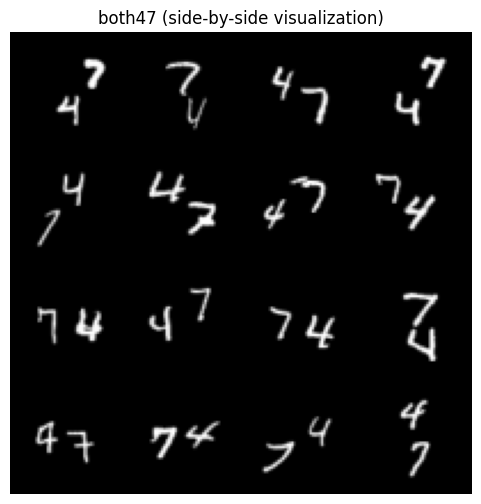

In [4]:
ds_exists4 = TwoDigitMNISTCanvasClean(mnist_train, mode="exists4", seed=0)
ds_exists7 = TwoDigitMNISTCanvasClean(mnist_train, mode="exists7", seed=1)
ds_both    = TwoDigitMNISTCanvasClean(mnist_train, mode="both47", enforce_side_by_side=True, seed=2)

xb, yb = next(iter(DataLoader(ds_exists4, batch_size=16, shuffle=True, num_workers=0)))
show_images_grid(xb, "exists4 (clean, random placement)")

xb, yb = next(iter(DataLoader(ds_exists7, batch_size=16, shuffle=True, num_workers=0)))
show_images_grid(xb, "exists7 (clean, random placement)")

xb, yb = next(iter(DataLoader(ds_both, batch_size=16, shuffle=True, num_workers=0)))
show_images_grid(xb, "both47 (side-by-side visualization)")


## Diffusion setup
We use epsilon prediction:
$$
x_t = \sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar\alpha_t}\epsilon,\quad
\min \|\epsilon - \epsilon_\theta(x_t,t)\|^2.
$$
We train by **steps**, maintain **EMA**, and sample using **DDIM** (optional ancestral DDPM).


In [5]:
@dataclass
class DiffusionConfig:
    T: int = 500
    beta_start: float = 1e-4
    beta_end: float = 0.02

class DiffusionSchedule:
    def __init__(self, cfg: DiffusionConfig, device):
        self.cfg = cfg
        T = cfg.T
        betas = torch.linspace(cfg.beta_start, cfg.beta_end, T, device=device)
        alphas = 1.0 - betas
        alpha_bar = torch.cumprod(alphas, dim=0)

        self.betas = betas
        self.alphas = alphas
        self.alpha_bar = alpha_bar

        self.sqrt_alpha_bar = torch.sqrt(alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        s1 = self.sqrt_alpha_bar[t].view(-1,1,1,1)
        s2 = self.sqrt_one_minus_alpha_bar[t].view(-1,1,1,1)
        return s1*x0 + s2*noise, noise

schedule = DiffusionSchedule(DiffusionConfig(T=500), device=device)


## Model: FullyConvExpertBigger
Fully convolutional (translation-friendly), configurable capacity via `base` and `n_blocks`.


In [6]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device) / (half - 1))
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb

class ResBlock(nn.Module):
    def __init__(self, c, tdim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, c)
        self.conv1 = nn.Conv2d(c, c, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, c)
        self.conv2 = nn.Conv2d(c, c, 3, padding=1)
        self.to_time = nn.Linear(tdim, c)

    def forward(self, x, t_emb):
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.to_time(t_emb).view(-1, h.size(1), 1, 1)
        h = self.conv2(F.silu(self.norm2(h)))
        return x + h

class FullyConvExpertBigger(nn.Module):
    def __init__(self, in_ch=1, base=96, tdim=128, n_blocks=6):
        super().__init__()
        self.time = SinusoidalTimeEmbedding(tdim)
        self.time_mlp = nn.Sequential(nn.Linear(tdim, tdim), nn.SiLU(), nn.Linear(tdim, tdim))

        self.in_conv = nn.Conv2d(in_ch, base, 3, padding=1)
        self.blocks = nn.ModuleList([ResBlock(base, tdim) for _ in range(n_blocks)])
        self.mid = nn.Conv2d(base, base, 3, padding=1)
        self.out = nn.Conv2d(base, in_ch, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(self.time(t))
        h = F.silu(self.in_conv(x))
        for b in self.blocks:
            h = b(h, t_emb)
        h = F.silu(self.mid(h))
        return self.out(h)


## Training by steps + EMA
We train for a fixed number of optimization steps and maintain EMA weights. Sampling uses EMA.


In [7]:
class EMA:
    def __init__(self, model: nn.Module, decay=0.9999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items()}

    @torch.no_grad()
    def update(self, model: nn.Module):
        msd = model.state_dict()
        for k, v in msd.items():
            self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1.0 - self.decay)

    @torch.no_grad()
    def copy_to(self, model: nn.Module):
        model.load_state_dict(self.shadow, strict=True)

def train_expert_steps(
    model: nn.Module,
    dl: DataLoader,
    schedule: DiffusionSchedule,
    max_steps=50_000,
    lr=2e-4,
    grad_clip=1.0,
    ema_decay=0.9999,
    log_every=500,
):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    ema = EMA(model, decay=ema_decay)
    model.train()

    losses = []
    t0 = time.time()
    it = iter(dl)

    for step in range(1, max_steps + 1):
        try:
            x0, _ = next(it)
        except StopIteration:
            it = iter(dl)
            x0, _ = next(it)

        x0 = x0.to(device)  # [-1,1]
        B = x0.size(0)
        t = torch.randint(0, schedule.cfg.T, (B,), device=device)
        xt, eps = schedule.q_sample(x0, t)

        eps_pred = model(xt, t)
        loss = F.mse_loss(eps_pred, eps)

        opt.zero_grad()
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()

        ema.update(model)
        losses.append(loss.item())

        if step % log_every == 0:
            dt = time.time() - t0
            print(f"step {step}/{max_steps} | loss={np.mean(losses[-log_every:]):.4f} | time={dt:.1f}s")

    return model, ema, losses


## Sampling
- **DDIM** (default): fast and typically cleaner.
- Optional ancestral DDPM (slower / noisier).

PoE sampling composes eps predictions:
$$
\epsilon_{poe} = w_4\epsilon_4 + w_7\epsilon_7,
$$
with optional per-sample eps normalization to stabilize composition.


In [8]:
@torch.no_grad()
def ddim_sample(model, schedule: DiffusionSchedule, shape, steps=100, eta=0.0, seed=0):
    seed_all(seed)
    model.eval()
    x = torch.randn(shape, device=device)
    T = schedule.cfg.T
    t_seq = torch.linspace(T-1, 0, steps, device=device).long()

    for i in range(len(t_seq)):
        t = t_seq[i].item()
        tt = torch.full((shape[0],), t, device=device, dtype=torch.long)

        eps = model(x, tt)

        abar_t = schedule.alpha_bar[t]
        x0 = (x - torch.sqrt(1.0 - abar_t) * eps) / (torch.sqrt(abar_t) + 1e-8)

        if i == len(t_seq) - 1:
            x = x0
            break

        t_prev = t_seq[i+1].item()
        abar_prev = schedule.alpha_bar[t_prev]

        # deterministic DDIM when eta=0
        sigma = 0.0
        if eta > 0:
            sigma = eta * torch.sqrt((1-abar_prev)/(1-abar_t)) * torch.sqrt(1 - abar_t/(abar_prev + 1e-8) + 1e-8)

        z = torch.randn_like(x) if eta > 0 else torch.zeros_like(x)
        x = torch.sqrt(abar_prev) * x0 + torch.sqrt(1-abar_prev) * eps + sigma * z

    return x


@torch.no_grad()
def ddim_sample_poe(model4, model7, schedule: DiffusionSchedule, shape, steps=100, eta=0.0,
                    w4=1.0, w7=1.0, normalize_eps=True, seed=0):
    seed_all(seed)
    model4.eval(); model7.eval()
    x = torch.randn(shape, device=device)
    T = schedule.cfg.T
    t_seq = torch.linspace(T-1, 0, steps, device=device).long()

    for i in range(len(t_seq)):
        t = t_seq[i].item()
        tt = torch.full((shape[0],), t, device=device, dtype=torch.long)

        eps4 = model4(x, tt)
        eps7 = model7(x, tt)
        if normalize_eps:
            eps4 = eps4 / (eps4.std(dim=(1,2,3), keepdim=True) + 1e-6)
            eps7 = eps7 / (eps7.std(dim=(1,2,3), keepdim=True) + 1e-6)

        eps = w4*eps4 + w7*eps7

        abar_t = schedule.alpha_bar[t]
        x0 = (x - torch.sqrt(1.0 - abar_t) * eps) / (torch.sqrt(abar_t) + 1e-8)

        if i == len(t_seq) - 1:
            x = x0
            break

        t_prev = t_seq[i+1].item()
        abar_prev = schedule.alpha_bar[t_prev]

        sigma = 0.0
        if eta > 0:
            sigma = eta * torch.sqrt((1-abar_prev)/(1-abar_t)) * torch.sqrt(1 - abar_t/(abar_prev + 1e-8) + 1e-8)

        z = torch.randn_like(x) if eta > 0 else torch.zeros_like(x)
        x = torch.sqrt(abar_prev) * x0 + torch.sqrt(1-abar_prev) * eps + sigma * z

    return x


# Optional: ancestral DDPM sampler (not required for the main results)
@torch.no_grad()
def ddpm_ancestral_sample(model, schedule: DiffusionSchedule, shape, seed=0):
    seed_all(seed)
    model.eval()
    x = torch.randn(shape, device=device)

    T = schedule.cfg.T
    for t in reversed(range(T)):
        tt = torch.full((shape[0],), t, device=device, dtype=torch.long)
        eps = model(x, tt)

        beta_t = schedule.betas[t]
        alpha_t = schedule.alphas[t]
        abar_t = schedule.alpha_bar[t]

        coef = (1 - alpha_t) / torch.sqrt(1 - abar_t)
        mean = (x - coef * eps) / torch.sqrt(alpha_t)

        if t > 0:
            x = mean + torch.sqrt(beta_t) * torch.randn_like(x)
        else:
            x = mean
    return x


## Existential evaluation
Train a 28×28 MNIST classifier, then compute existential scores on 48×48 samples by sliding a 28×28 window and taking max class probability.

Metrics reported:
- mean exists4
- mean exists7
- mean min(exists4, exists7) as a proxy for (4 ∧ 7)


In [9]:
class SmallMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
            nn.Flatten(),
            nn.Linear(64*7*7, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

def train_mnist_classifier(epochs=2, bs=256, lr=1e-3):
    clf = SmallMNISTClassifier().to(device)
    opt = torch.optim.Adam(clf.parameters(), lr=lr)
    dl = DataLoader(mnist_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)

    clf.train()
    for ep in range(epochs):
        for i, (x,y) in enumerate(dl):
            x = x.to(device)  # [0,1]
            y = y.to(device)
            loss = F.cross_entropy(clf(x), y)
            opt.zero_grad(); loss.backward(); opt.step()
        print(f"classifier epoch {ep+1}/{epochs} done")
    return clf

@torch.no_grad()
def existence_scores_48(x48, clf, digit: int):
    if x48.min() < 0:
        x48 = (x48 + 1) / 2
    x48 = x48.clamp(0, 1)

    probs = []
    for top in range(0, 48-28+1):
        for left in range(0, 48-28+1):
            patch = x48[:, :, top:top+28, left:left+28].to(device)
            p = torch.softmax(clf(patch), dim=1)[:, digit]
            probs.append(p)
    probs = torch.stack(probs, dim=1)  # [B, 21*21]
    return probs.max(dim=1).values

@torch.no_grad()
def eval_existential(x, clf):
    s4 = existence_scores_48(x, clf, 4).detach().cpu().numpy()
    s7 = existence_scores_48(x, clf, 7).detach().cpu().numpy()
    return {
        "mean_exists4": float(s4.mean()),
        "mean_exists7": float(s7.mean()),
        "mean_exists_both_proxy": float(np.minimum(s4, s7).mean())
    }

clf = train_mnist_classifier(epochs=2)


classifier epoch 1/2 done
classifier epoch 2/2 done


## PoE weight sweep
We sweep (w4, w7) and rank by proxy `min(exists4, exists7)` on generated PoE samples.


In [10]:
def poe_weight_sweep(
    model4, model7,
    schedule: DiffusionSchedule,
    clf,
    shape=(64,1,48,48),
    ddim_steps=100,
    eta=0.0,
    weights=(0.5, 1.0, 2.0, 3.0, 4.0),
    normalize_eps=True,
    seed=123
):
    rows = []
    for w4 in weights:
        for w7 in weights:
            x = ddim_sample_poe(model4, model7, schedule, shape,
                                steps=ddim_steps, eta=eta, w4=w4, w7=w7,
                                normalize_eps=normalize_eps, seed=seed)
            m = eval_existential(x, clf)
            m.update({"w4": w4, "w7": w7})
            rows.append(m)

    rows = sorted(rows, key=lambda d: d["mean_exists_both_proxy"], reverse=True)
    print("Top PoE configs:")
    for r in rows[:8]:
        print(r)
    return rows


# Regime A: Support mismatch (expected failure)

Train p4 and p7 on standard MNIST digits (single centered digit).
We embed each 28×28 digit into a 48×48 canvas by padding (centered).

Expectation:
- intersection support for (4 ∧ 7) is absent → PoE does not produce clear co-occurrence.


In [ ]:
def filter_digit_subset(mnist_ds, digit: int):
    idx = [i for i, (_, y) in enumerate(mnist_ds) if int(y) == int(digit)]
    return torch.utils.data.Subset(mnist_ds, idx)

class PadTo48(Dataset):
    def __init__(self, base_subset):
        self.base = base_subset
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x, y = self.base[i]            # [1,28,28] in [0,1]
        x = TF.pad(x, [10,10,10,10])   # -> 48×48 centered
        x = x*2 - 1                    # [-1,1]
        return x, y

# DataLoaders
dl4A = DataLoader(PadTo48(filter_digit_subset(mnist_train, 4)),
                  batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
dl7A = DataLoader(PadTo48(filter_digit_subset(mnist_train, 7)),
                  batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Models
base = 96
n_blocks = 6
steps_train = 50_000

m4A = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device)
m7A = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device)

print("Training Regime A: p4")
m4A, ema4A, _ = train_expert_steps(m4A, dl4A, schedule, max_steps=steps_train, ema_decay=0.9999)
print("Training Regime A: p7")
m7A, ema7A, _ = train_expert_steps(m7A, dl7A, schedule, max_steps=steps_train, ema_decay=0.9999)

# EMA copies for sampling
m4A_ema = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device); ema4A.copy_to(m4A_ema)
m7A_ema = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device); ema7A.copy_to(m7A_ema)

# Samples
xpoeA = ddim_sample_poe(m4A_ema, m7A_ema, schedule, shape=(16,1,48,48),
                        steps=100, eta=0.0, w4=1.0, w7=1.0, normalize_eps=True, seed=0)

show_images_grid(xpoeA, "Regime A: PoE (EMA, DDIM) — expected failure")
print("Regime A eval:", eval_existential(xpoeA, clf))


# Regime B: Overlap possible but inductive-bias mismatch (expected weakness)

We use the curated dataset, but enforce *centered placements* by restricting the sampling region implicitly:
- We emulate center bias by using a smaller effective canvas region via large margins and smaller variability.
- (This keeps the model "happy" near center and less trained off-center.)

Expectation:
- experts become implicitly center-biased; PoE may not yield robust spatial co-occurrence.


In [ ]:
# Center bias via larger margins + narrower size range (digits tend to occupy central band more often).
# (Still clean non-overlap. Still existential labels.)
ds4B = TwoDigitMNISTCanvasClean(
    mnist_base=mnist_train,
    canvas_size=48,
    mode="exists4",
    digit_size_range=(20, 22),
    min_margin=14,          # big margin -> mostly near center
    enforce_side_by_side=False,
    seed=10
)
ds7B = TwoDigitMNISTCanvasClean(
    mnist_base=mnist_train,
    canvas_size=48,
    mode="exists7",
    digit_size_range=(20, 22),
    min_margin=14,
    enforce_side_by_side=False,
    seed=11
)

dl4B = DataLoader(ds4B, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn)
dl7B = DataLoader(ds7B, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn)

m4B = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device)
m7B = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device)

print("Training Regime B: p4")
m4B, ema4B, _ = train_expert_steps(m4B, dl4B, schedule, max_steps=steps_train, ema_decay=0.9999)
print("Training Regime B: p7")
m7B, ema7B, _ = train_expert_steps(m7B, dl7B, schedule, max_steps=steps_train, ema_decay=0.9999)

m4B_ema = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device); ema4B.copy_to(m4B_ema)
m7B_ema = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device); ema7B.copy_to(m7B_ema)

xpoeB = ddim_sample_poe(m4B_ema, m7B_ema, schedule, shape=(16,1,48,48),
                        steps=100, eta=0.0, w4=1.0, w7=1.0, normalize_eps=True, seed=1)

show_images_grid(xpoeB, "Regime B: PoE (EMA, DDIM) — expected weaker than C")
print("Regime B eval:", eval_existential(xpoeB, clf))


# Regime C: Overlap + matched semantics (expected success)

We use `TwoDigitMNISTCanvasCleanPlus`:
- random placement (location-agnostic training)
- optional distractors to enforce existential semantics
- clean non-overlap remains

Expectation:
- p4 samples contain a 4 somewhere
- p7 samples contain a 7 somewhere
- PoE sampling yields images with both (4 ∧ 7)

We additionally run a PoE weight sweep.


In [ ]:
ds4C = TwoDigitMNISTCanvasCleanPlus(
    mnist_base=mnist_train,
    canvas_size=48,
    mode="exists4",
    digit_size_range=(18, 22),
    min_margin=4,              # wide placement range
    p_extra=0.3, max_extra=1, forbid_digit=4,
    enforce_side_by_side=False,
    seed=20
)
ds7C = TwoDigitMNISTCanvasCleanPlus(
    mnist_base=mnist_train,
    canvas_size=48,
    mode="exists7",
    digit_size_range=(18, 22),
    min_margin=4,
    p_extra=0.3, max_extra=1, forbid_digit=7,
    enforce_side_by_side=False,
    seed=21
)

dl4C = DataLoader(ds4C, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn)
dl7C = DataLoader(ds7C, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn)

m4C = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device)
m7C = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device)

print("Training Regime C: p4")
m4C, ema4C, _ = train_expert_steps(m4C, dl4C, schedule, max_steps=steps_train, ema_decay=0.9999)
print("Training Regime C: p7")
m7C, ema7C, _ = train_expert_steps(m7C, dl7C, schedule, max_steps=steps_train, ema_decay=0.9999)

m4C_ema = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device); ema4C.copy_to(m4C_ema)
m7C_ema = FullyConvExpertBigger(base=base, n_blocks=n_blocks).to(device); ema7C.copy_to(m7C_ema)

# single expert samples
x4C = ddim_sample(m4C_ema, schedule, shape=(16,1,48,48), steps=100, eta=0.0, seed=2)
x7C = ddim_sample(m7C_ema, schedule, shape=(16,1,48,48), steps=100, eta=0.0, seed=3)
show_images_grid(x4C, "Regime C: p4 samples (EMA, DDIM)")
show_images_grid(x7C, "Regime C: p7 samples (EMA, DDIM)")
print("Regime C p4 eval:", eval_existential(x4C, clf))
print("Regime C p7 eval:", eval_existential(x7C, clf))

# PoE weight sweep
rows = poe_weight_sweep(m4C_ema, m7C_ema, schedule, clf,
                        shape=(64,1,48,48),
                        ddim_steps=100, eta=0.0,
                        weights=(0.5, 1.0, 2.0, 3.0, 4.0),
                        normalize_eps=True)

best = rows[0]
w4_best, w7_best = best["w4"], best["w7"]
print("Best weights:", (w4_best, w7_best), "Best metrics:", best)

xpoeC = ddim_sample_poe(m4C_ema, m7C_ema, schedule, shape=(16,1,48,48),
                        steps=100, eta=0.0, w4=w4_best, w7=w7_best,
                        normalize_eps=True, seed=4)
show_images_grid(xpoeC, f"Regime C: PoE (EMA, DDIM) | w4={w4_best} w7={w7_best}")
print("Regime C eval:", eval_existential(xpoeC, clf))


## Summary
We compare Regimes A–C by:
- qualitative samples
- existential metrics: mean exists4, mean exists7, mean min(exists4, exists7)

Expected ordering of performance on the conjunction proxy:
Regime C  >  Regime B  >  Regime A
